# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from math import * 
from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split
from   sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

from sklearn.ensemble import (
    BaggingClassifier,
    StackingClassifier,
    AdaBoostClassifier, 
    ExtraTreesClassifier,
    RandomForestClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from pycaret.classification import ClassificationExperiment



# 2. Load Data

In [9]:
data = pd.read_csv('../Dataset/StudentsPerformance.csv').drop_duplicates()
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


# 3. Initial Analysis

### 3.1. Metadata

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 70.3+ KB


In [8]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
math score,1000.0,66.089,15.163080,0.0,57.00,66.0,77.0,100.0
reading score,1000.0,69.169,14.600192,17.0,59.00,70.0,79.0,100.0
writing score,1000.0,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


In [9]:
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [14]:
no_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/no_of_columns
print(percentage_of_missing_data)

gender                         0.0
race/ethnicity                 0.0
parental level of education    0.0
lunch                          0.0
test preparation course        0.0
math score                     0.0
reading score                  0.0
writing score                  0.0
dtype: float64


In [10]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


In [11]:
data.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

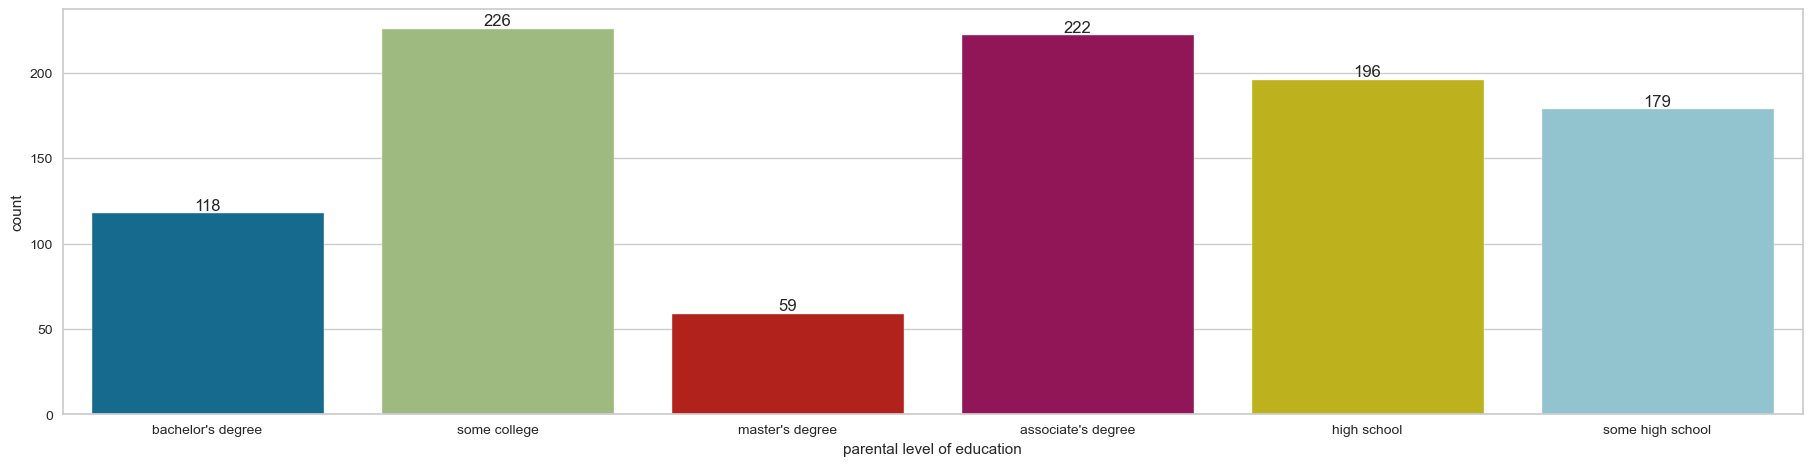

In [13]:
plt.subplots(figsize=(20,5))
ax = sns.countplot(data, x=data['parental level of education'])
ax.bar_label(ax.containers[0])
plt.show()

### 3.2. Columns Processing

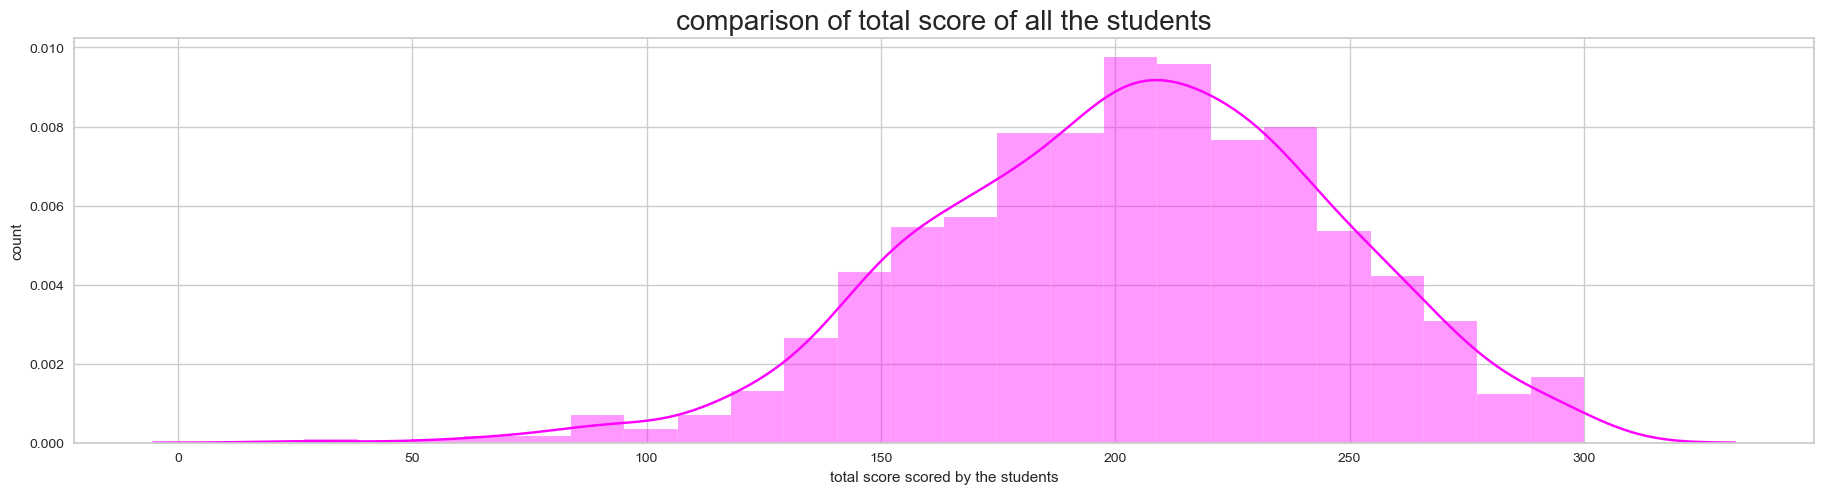

In [10]:
data['total_score'] = data['math score'] + data['reading score'] + data['writing score']

plt.subplots(figsize=(20,5))
sns.distplot(data['total_score'], color = 'magenta')

plt.title('comparison of total score of all the students', fontweight = 30, fontsize = 20)
plt.xlabel('total score scored by the students')
plt.ylabel('count')
plt.show()

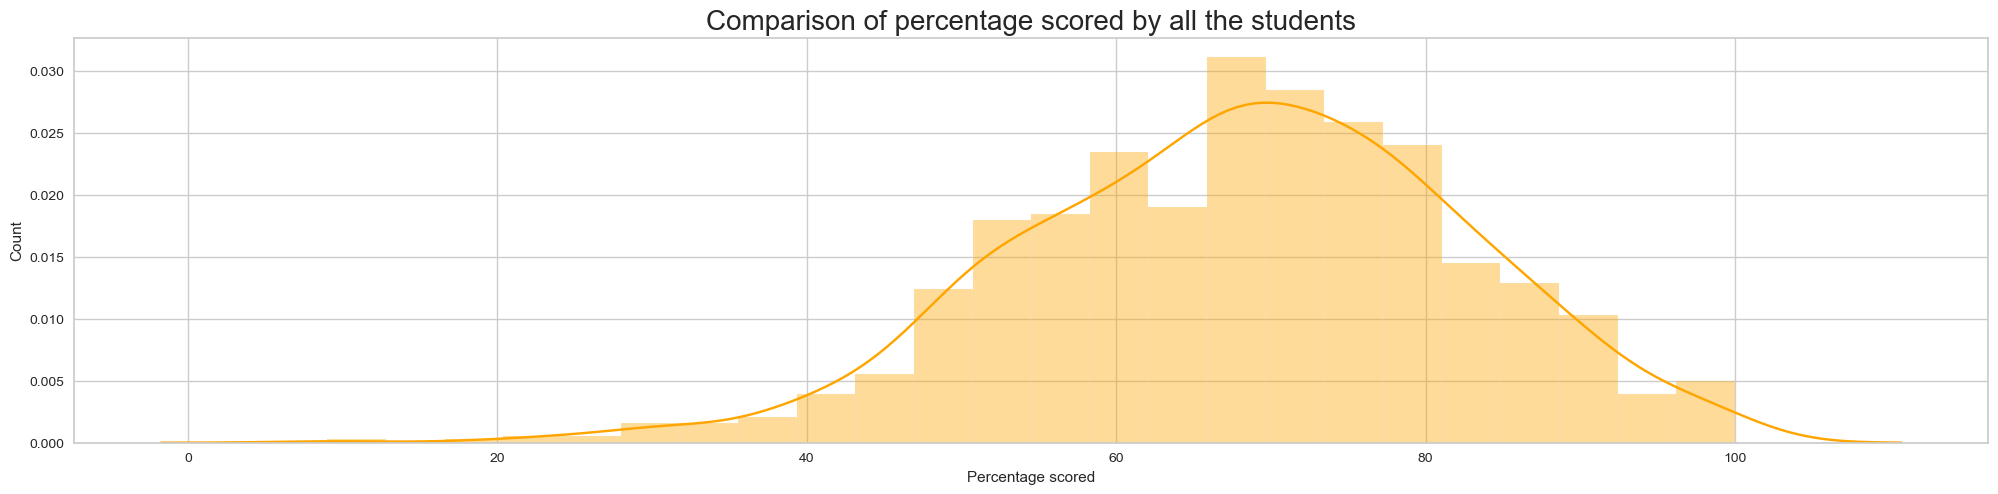

In [11]:
data['percentage'] = data['total_score']/3
data['percentage'] = data['percentage'].apply(np.ceil)

plt.rcParams['figure.figsize'] = (22, 5)
sns.distplot(data['percentage'], color = 'orange')

plt.title('Comparison of percentage scored by all the students', fontweight = 30, fontsize = 20)
plt.xlabel('Percentage scored')
plt.ylabel('Count')
plt.show()

In [12]:
def get_pass_or_not(score):
    if score >= 70:
        return 'Pass'
    elif score < 70:
        return 'Not Pass'
    
data['pass_math'] = data['math score'].apply(lambda x: get_pass_or_not(x))
data['pass_reading'] = data['reading score'].apply(lambda x: get_pass_or_not(x))
data['pass_writing'] = data['writing score'].apply(lambda x: get_pass_or_not(x))

In [13]:
def getgrade(percentage):
  if(percentage >= 90):
    return 'A'
  if(percentage >= 80):
    return 'B'
  if(percentage >= 70):
    return 'C'
  if(percentage >= 60):
    return 'D'
  if(percentage >= 40):
    return 'E'
  else :
    return 'F'

data['grades'] = data.apply(lambda x: getgrade(x['percentage']), axis = 1 )

data['grades'].value_counts()

C    260
D    252
E    248
B    156
A     58
F     26
Name: grades, dtype: int64

In [14]:
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_score,percentage,pass_math,pass_reading,pass_writing,grades
0,female,group B,bachelor's degree,standard,none,72,72,74,218,73.0,Pass,Pass,Pass,C
1,female,group C,some college,standard,completed,69,90,88,247,83.0,Not Pass,Pass,Pass,B
2,female,group B,master's degree,standard,none,90,95,93,278,93.0,Pass,Pass,Pass,A
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,50.0,Not Pass,Not Pass,Not Pass,E
4,male,group C,some college,standard,none,76,78,75,229,77.0,Pass,Pass,Pass,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95,282,94.0,Pass,Pass,Pass,A
996,male,group C,high school,free/reduced,none,62,55,55,172,58.0,Not Pass,Not Pass,Not Pass,E
997,female,group C,high school,free/reduced,completed,59,71,65,195,65.0,Not Pass,Pass,Not Pass,D
998,female,group D,some college,standard,completed,68,78,77,223,75.0,Not Pass,Pass,Pass,C


In [17]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score', 'total_score', 'percentage', 'pass_math', 'pass_reading', 'pass_writing', 'grades']
Categorical Columns : []


In [16]:
def change_columns_to_numerical(data):
    LE = LabelEncoder()

    for column in categorical_columns:
        data[column] = LE.fit_transform(data[column])
        data[column] = data[column].astype('int8')
        print(f'{column} : {LE.classes_}') 
    return data

data = change_columns_to_numerical(data)

gender : ['female' 'male']
race/ethnicity : ['group A' 'group B' 'group C' 'group D' 'group E']
parental level of education : ["associate's degree" "bachelor's degree" 'high school' "master's degree"
 'some college' 'some high school']
lunch : ['free/reduced' 'standard']
test preparation course : ['completed' 'none']
pass_math : ['Not Pass' 'Pass']
pass_reading : ['Not Pass' 'Pass']
pass_writing : ['Not Pass' 'Pass']
grades : ['A' 'B' 'C' 'D' 'E' 'F']


### 3.3. EDA

In [18]:
data[['lunch','gender','math score','writing score','reading score']] \
    .groupby(['lunch','gender']) \
    .agg('median')

math score  writing score  reading score
lunch gender                                          
0     0             57.0           68.0           67.0
      1             62.0           59.0           61.0
1     0             67.0           76.0           75.0
      1             72.0           67.0           67.5

In [19]:
data[['test preparation course', 'gender', 'math score', 'writing score', 'reading score']] \
    .groupby(['test preparation course','gender']) \
    .agg('median')

math score  writing score  reading score
test preparation course gender                                          
0                       0             67.0           79.0           78.0
                        1             73.0           70.0           71.0
1                       0             62.0           70.0           71.0
                        1             67.0           60.0           63.0

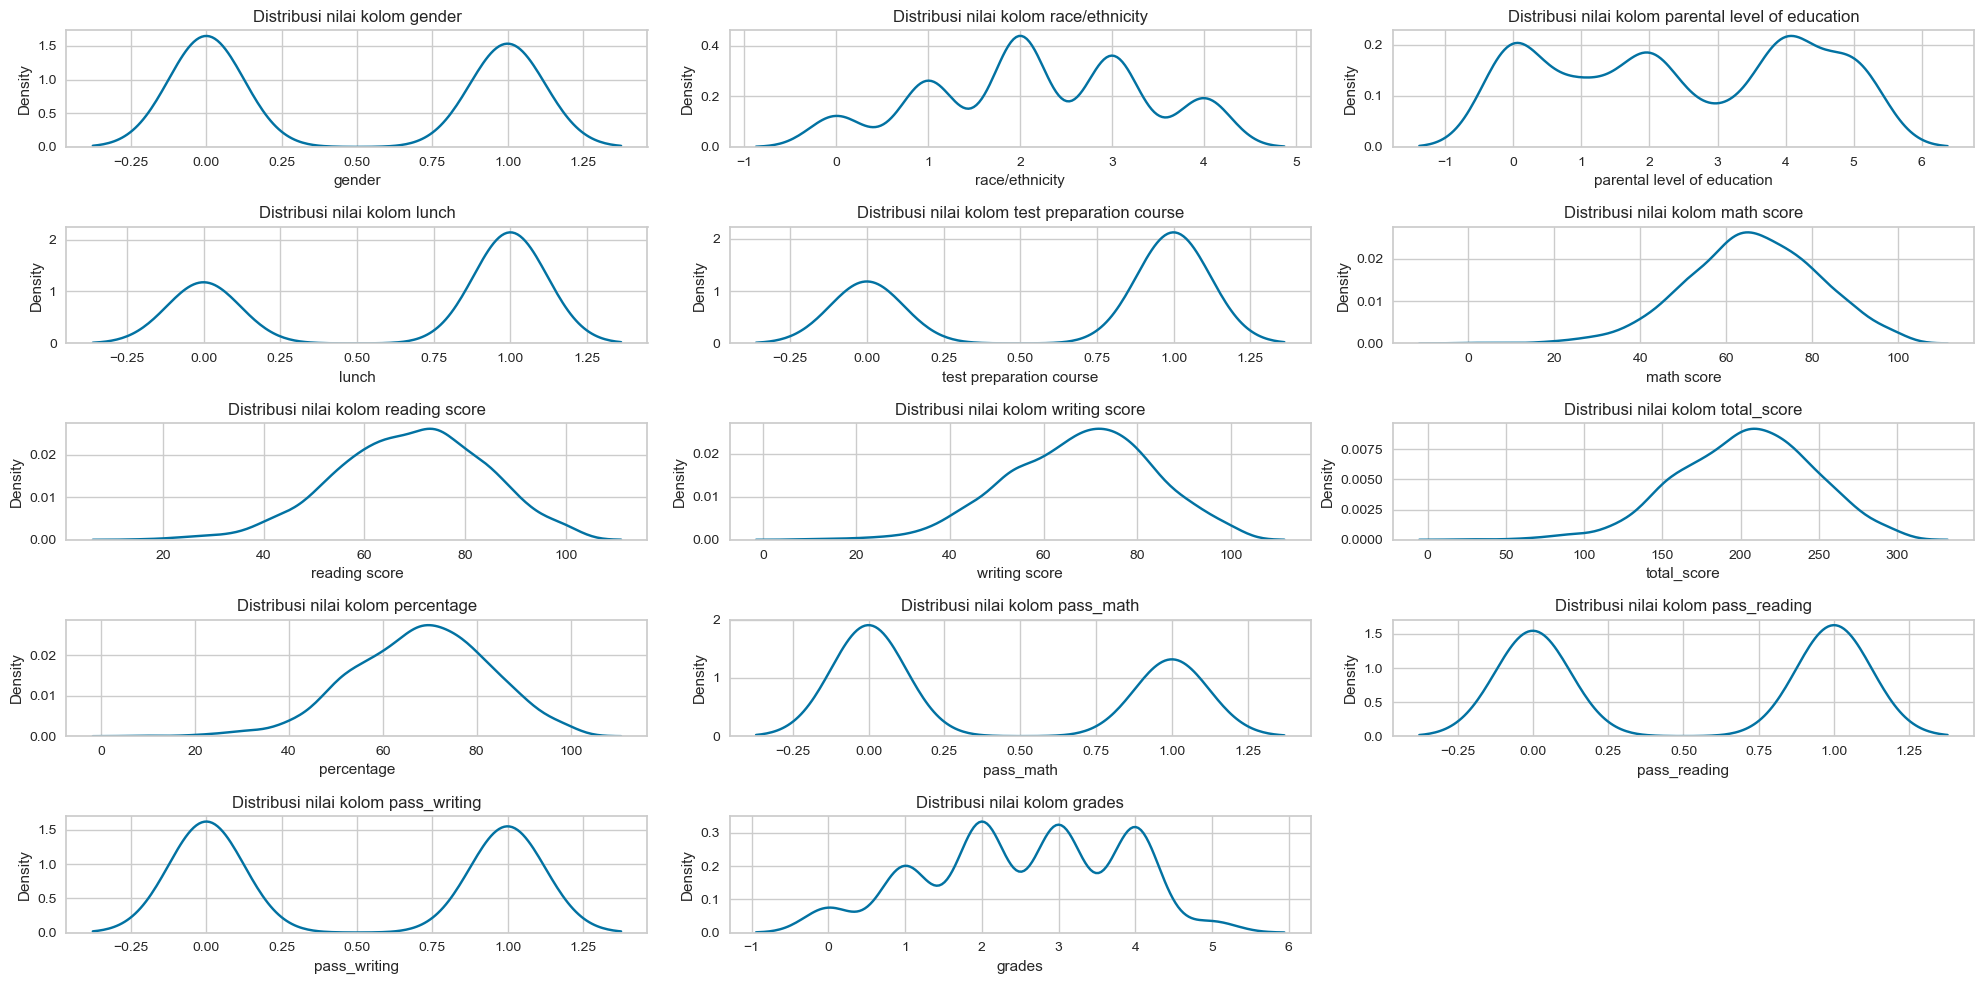

In [21]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

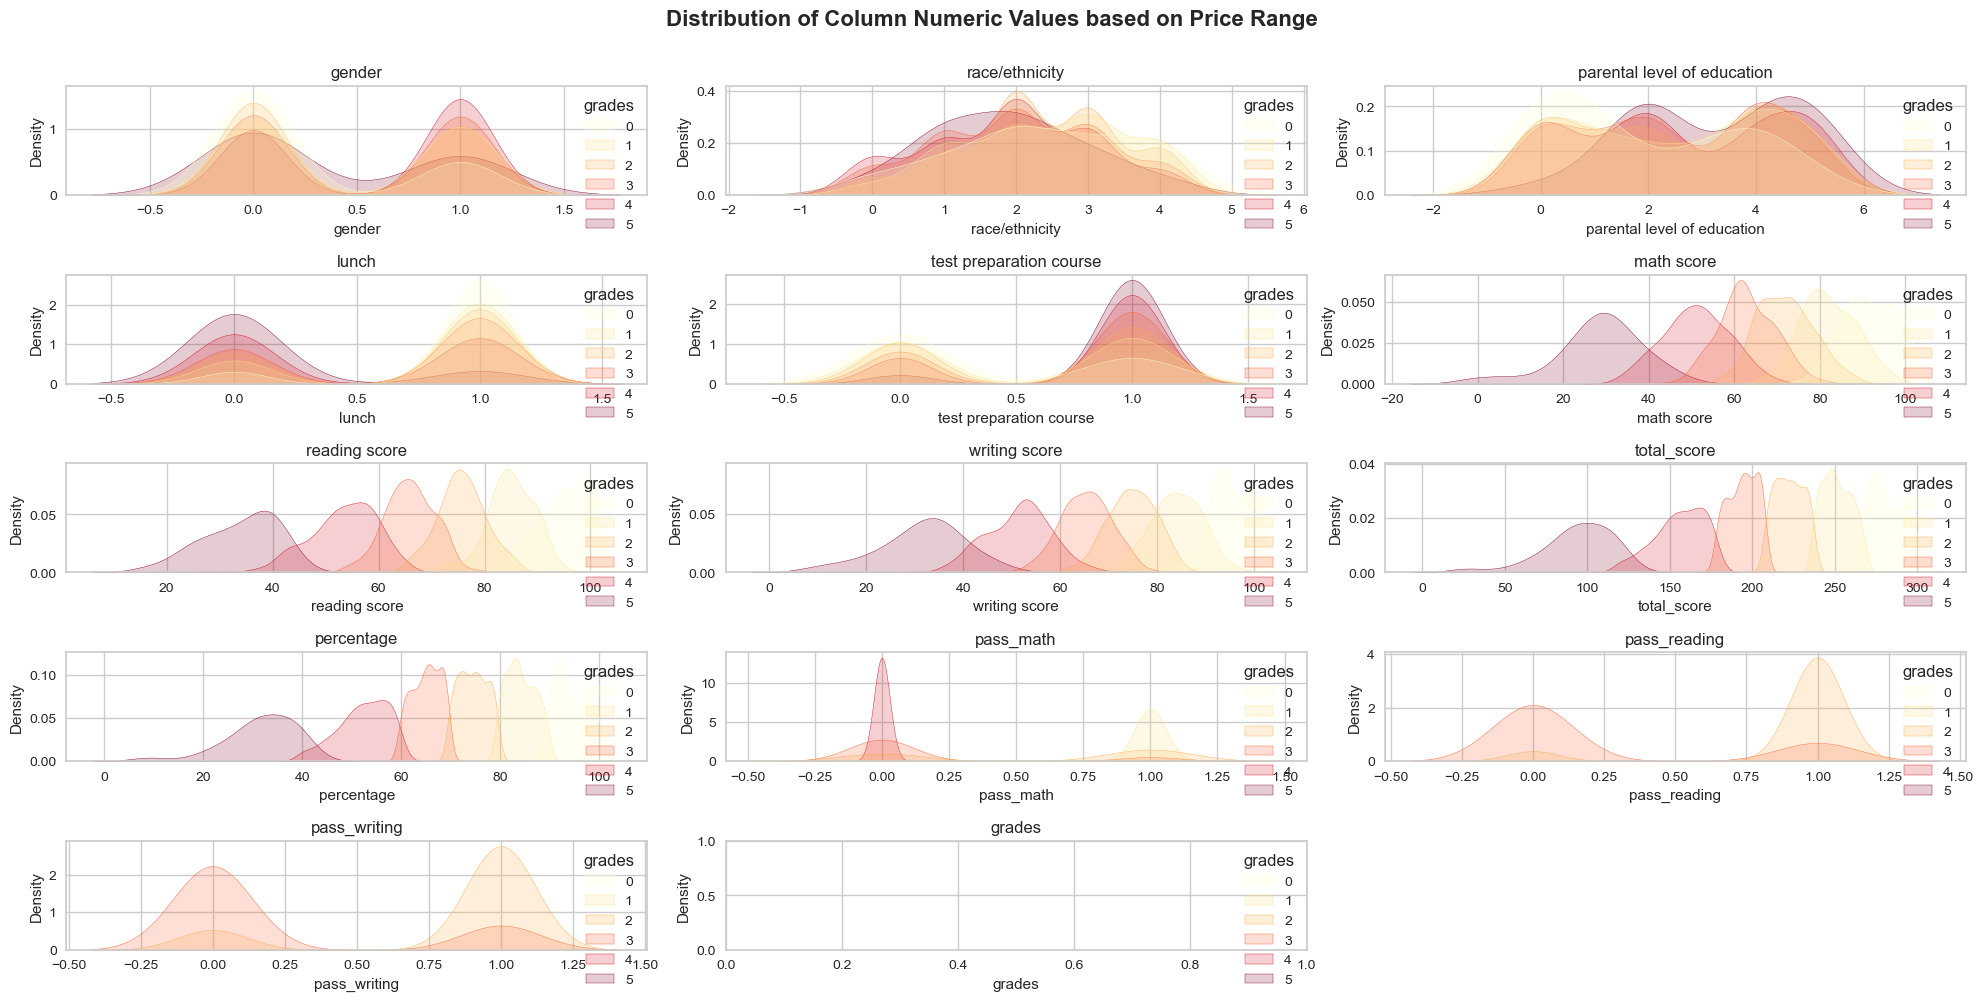

In [23]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="grades", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Price Range', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# plt.figure(figsize=(20, 10))

# plt.scatter(data.age[data.target==1],
#             data.thalach[data.target==1],
#             c="salmon")

# plt.scatter(data.age[data.target==0],
#             data.thalach[data.target==0],
#             c="lightblue")

# plt.title("Heart Disease in function of Age and Max Heart Rate")
# plt.xlabel("Age")
# plt.ylabel("Max Heart Rate")
# plt.legend(["Disease", "No Disease"])

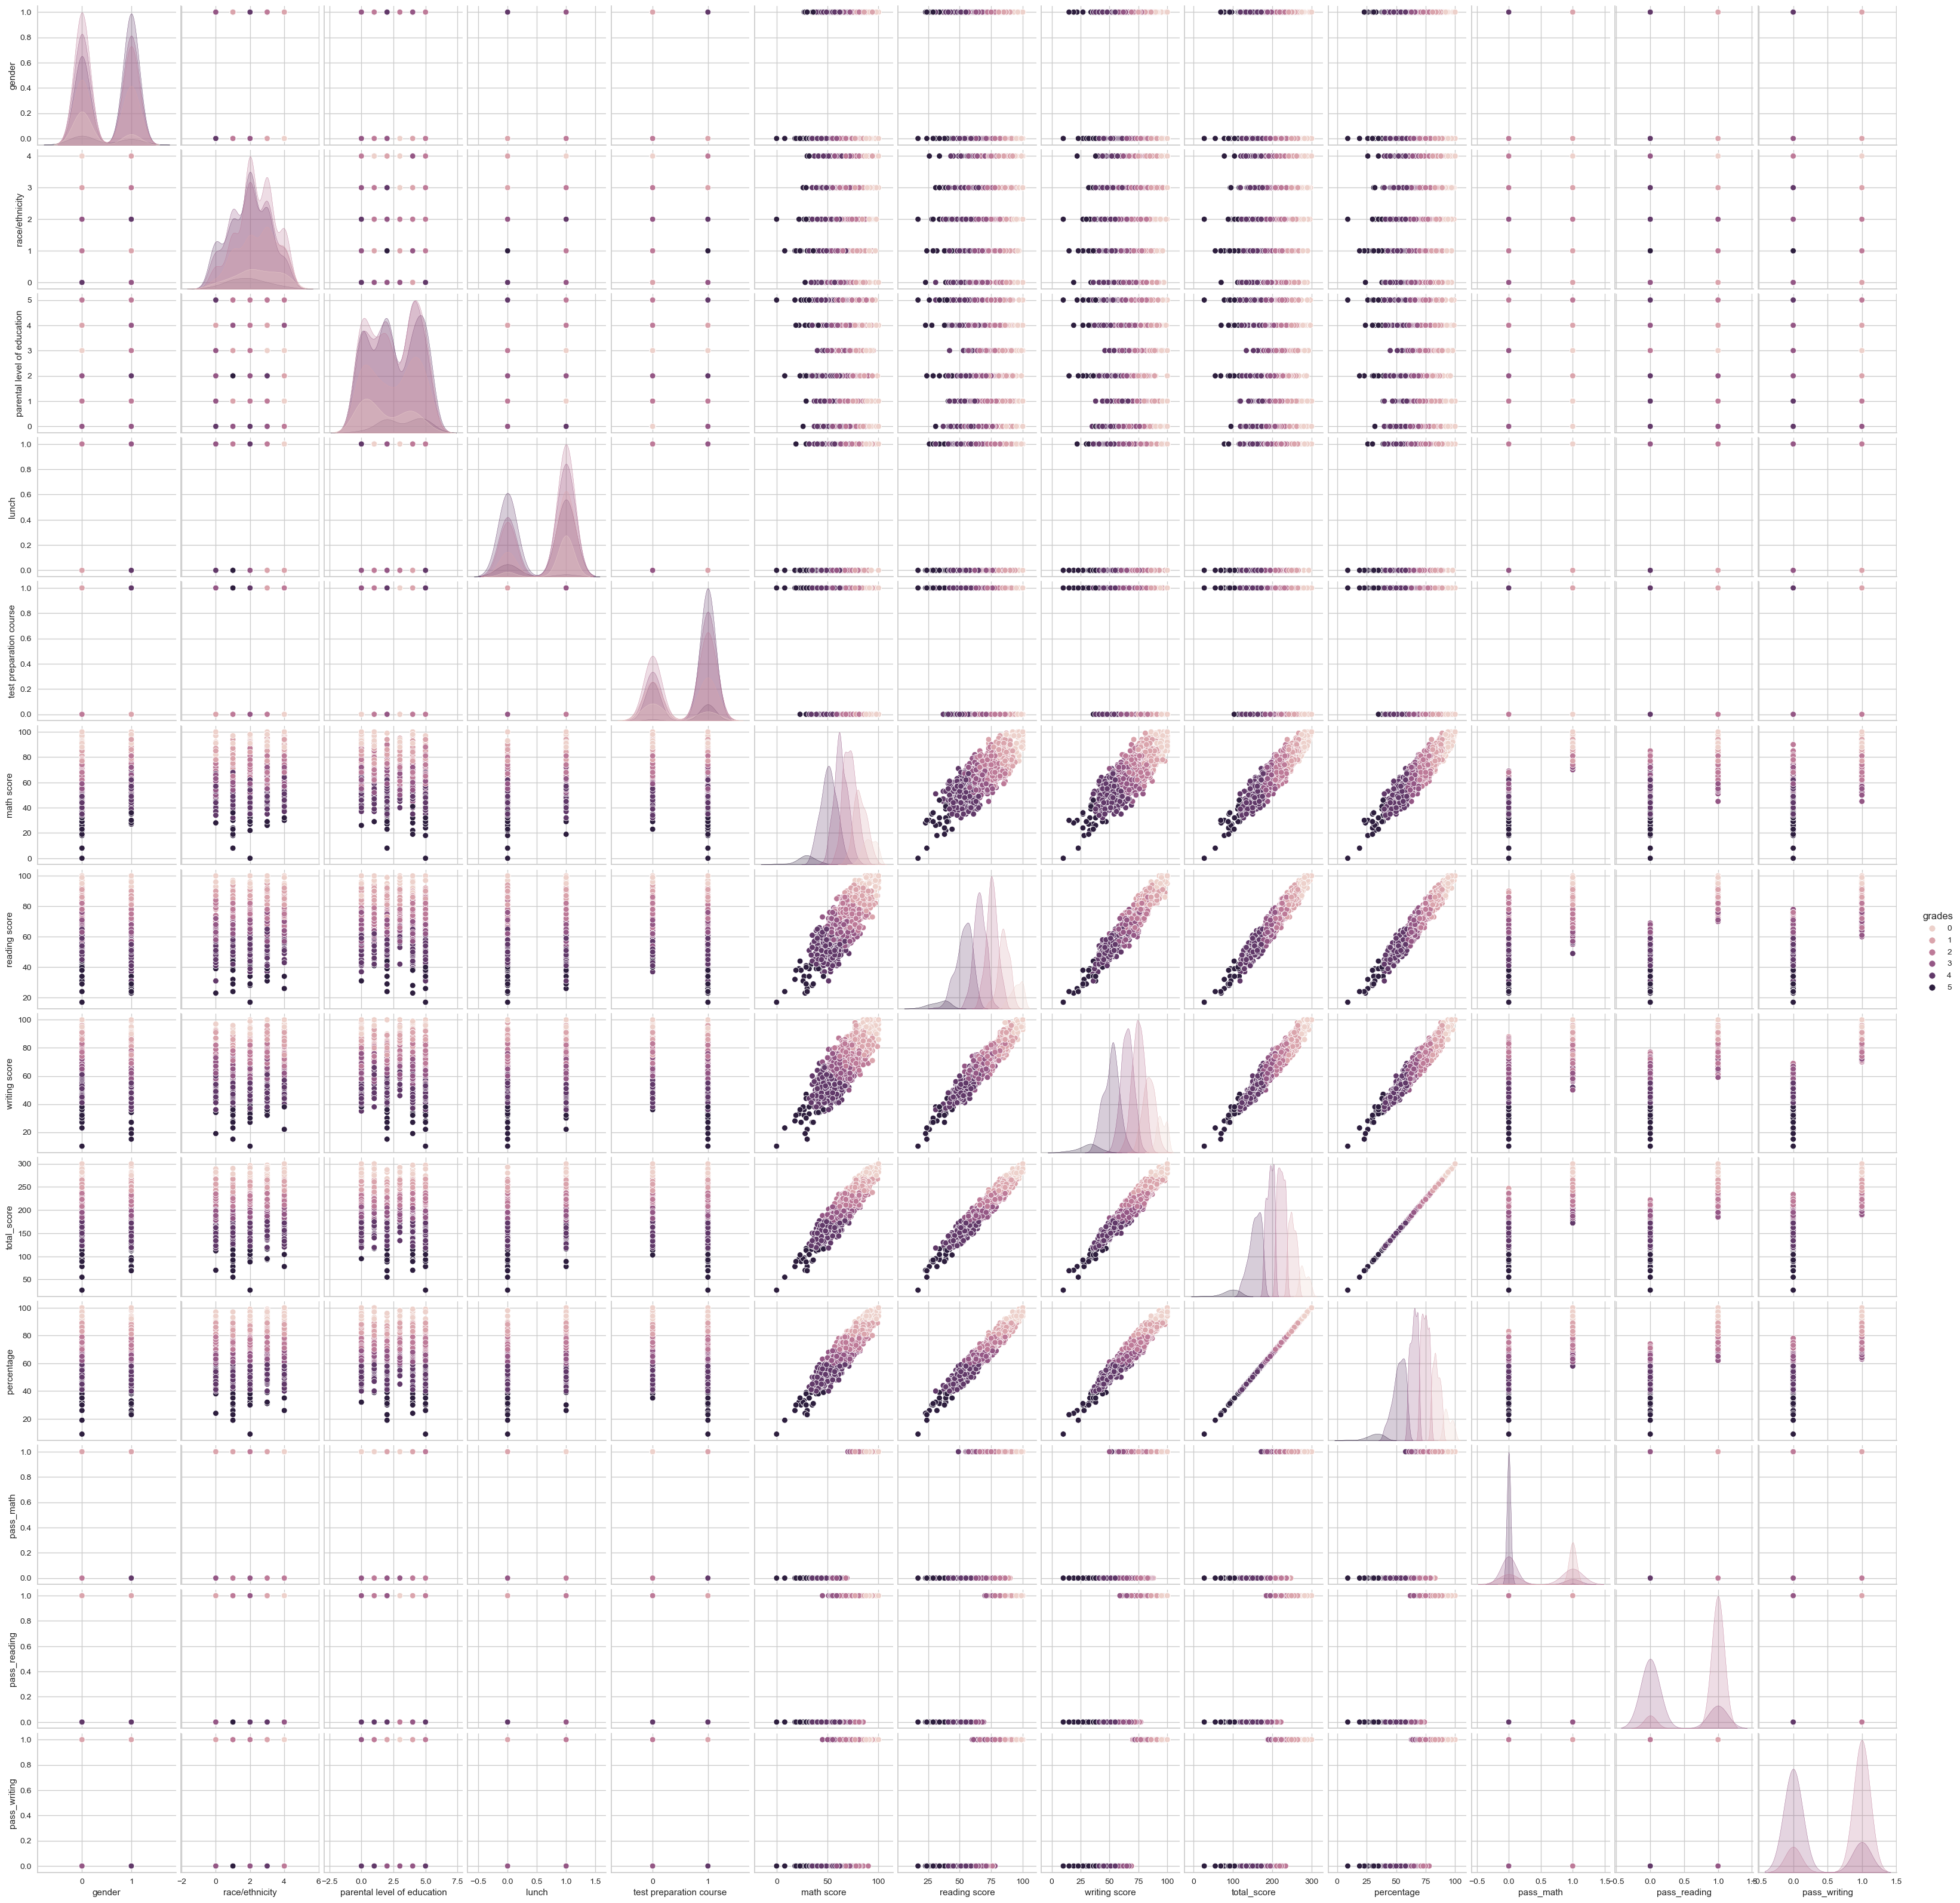

In [25]:
sns.pairplot(data, hue='grades')

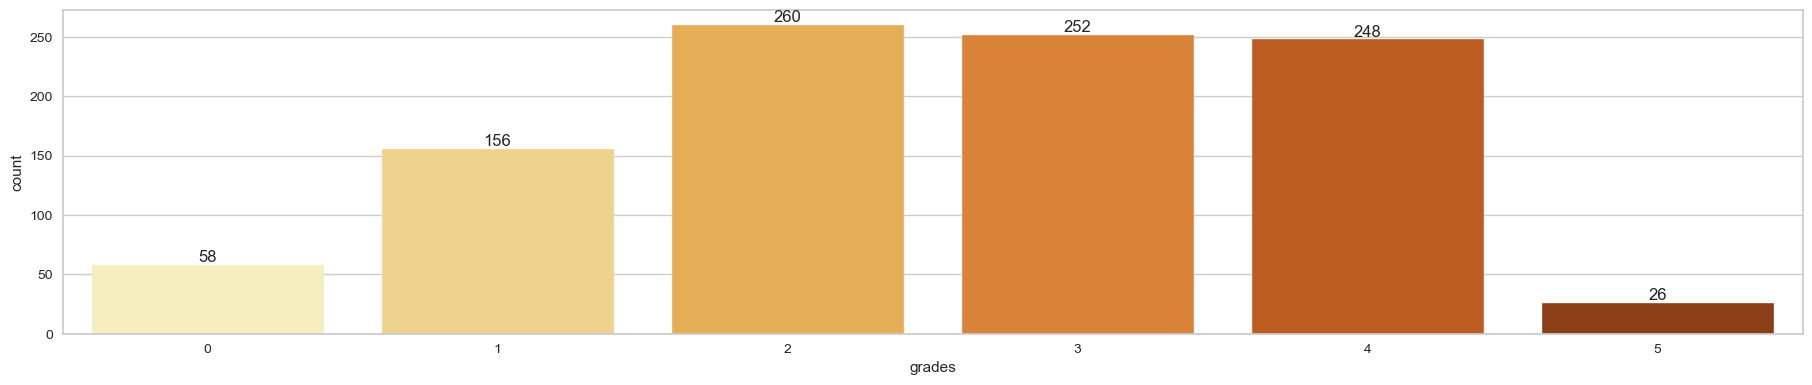

In [27]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'grades', palette='YlOrBr')
ax.bar_label(ax.containers[0])
plt.show()

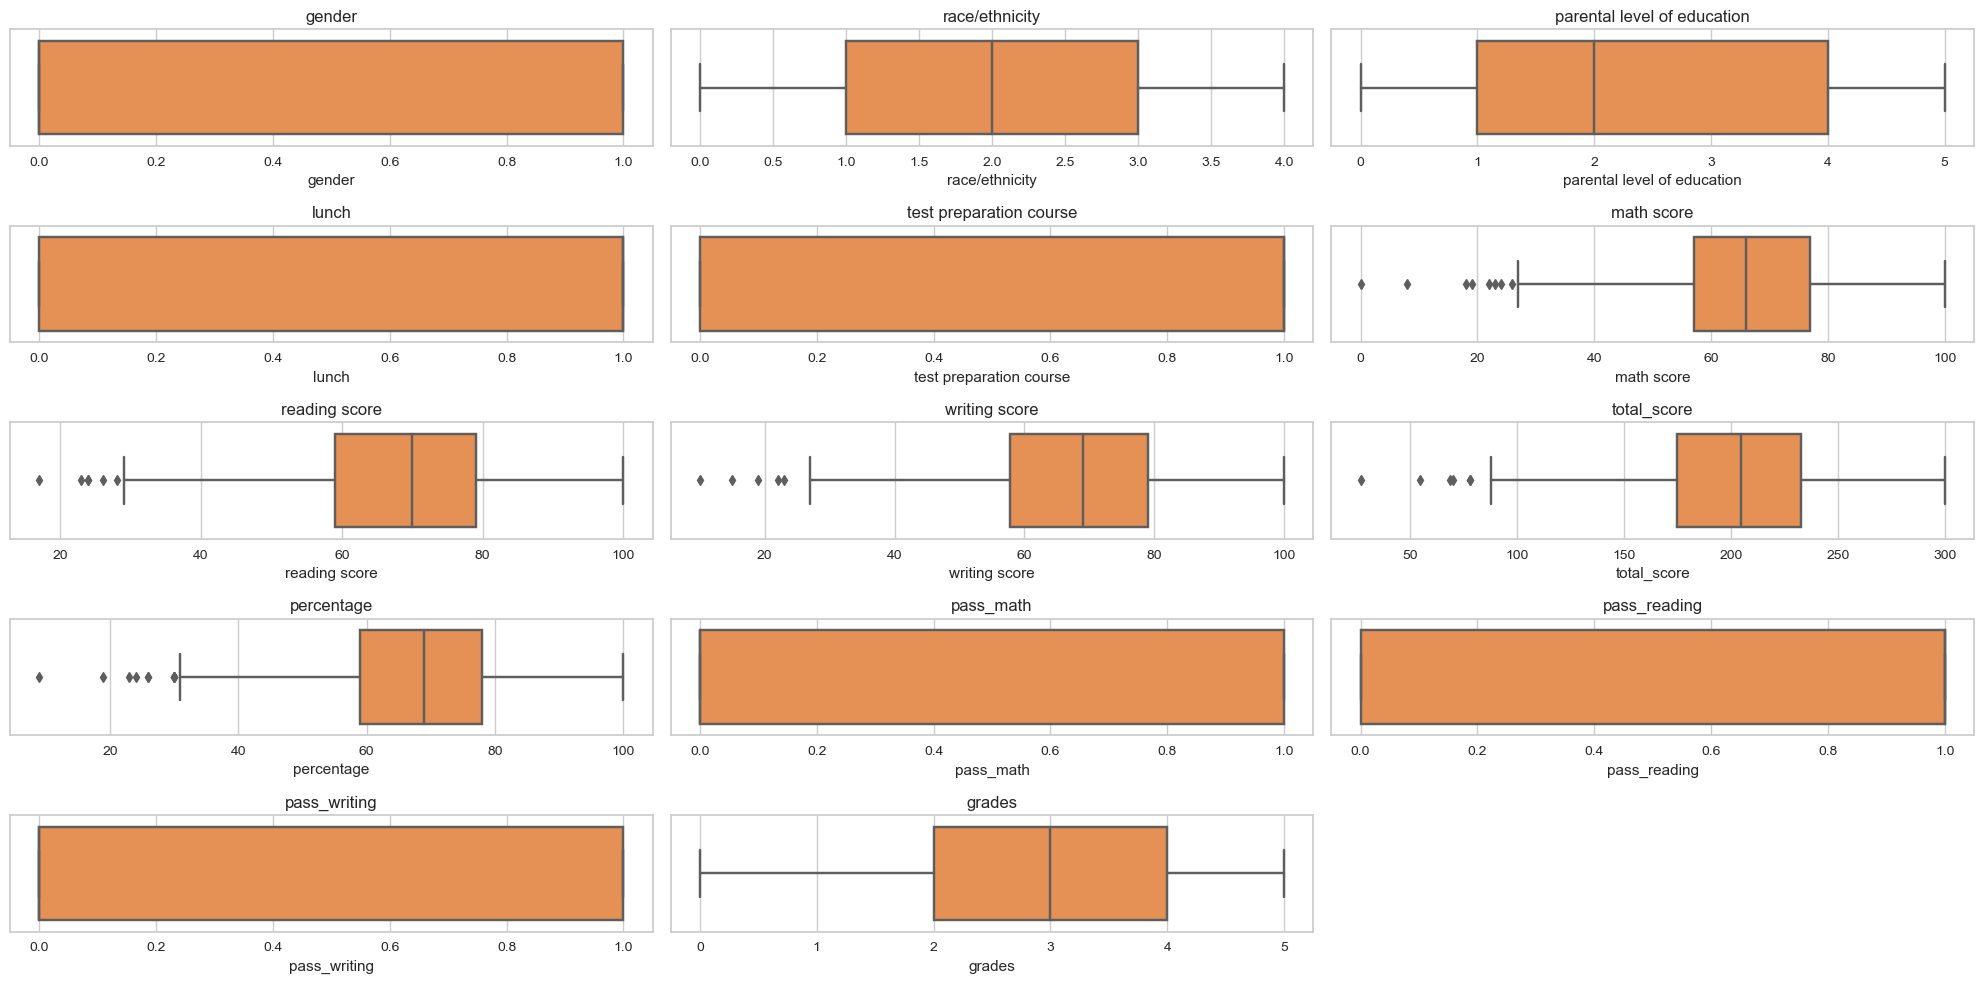

In [29]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

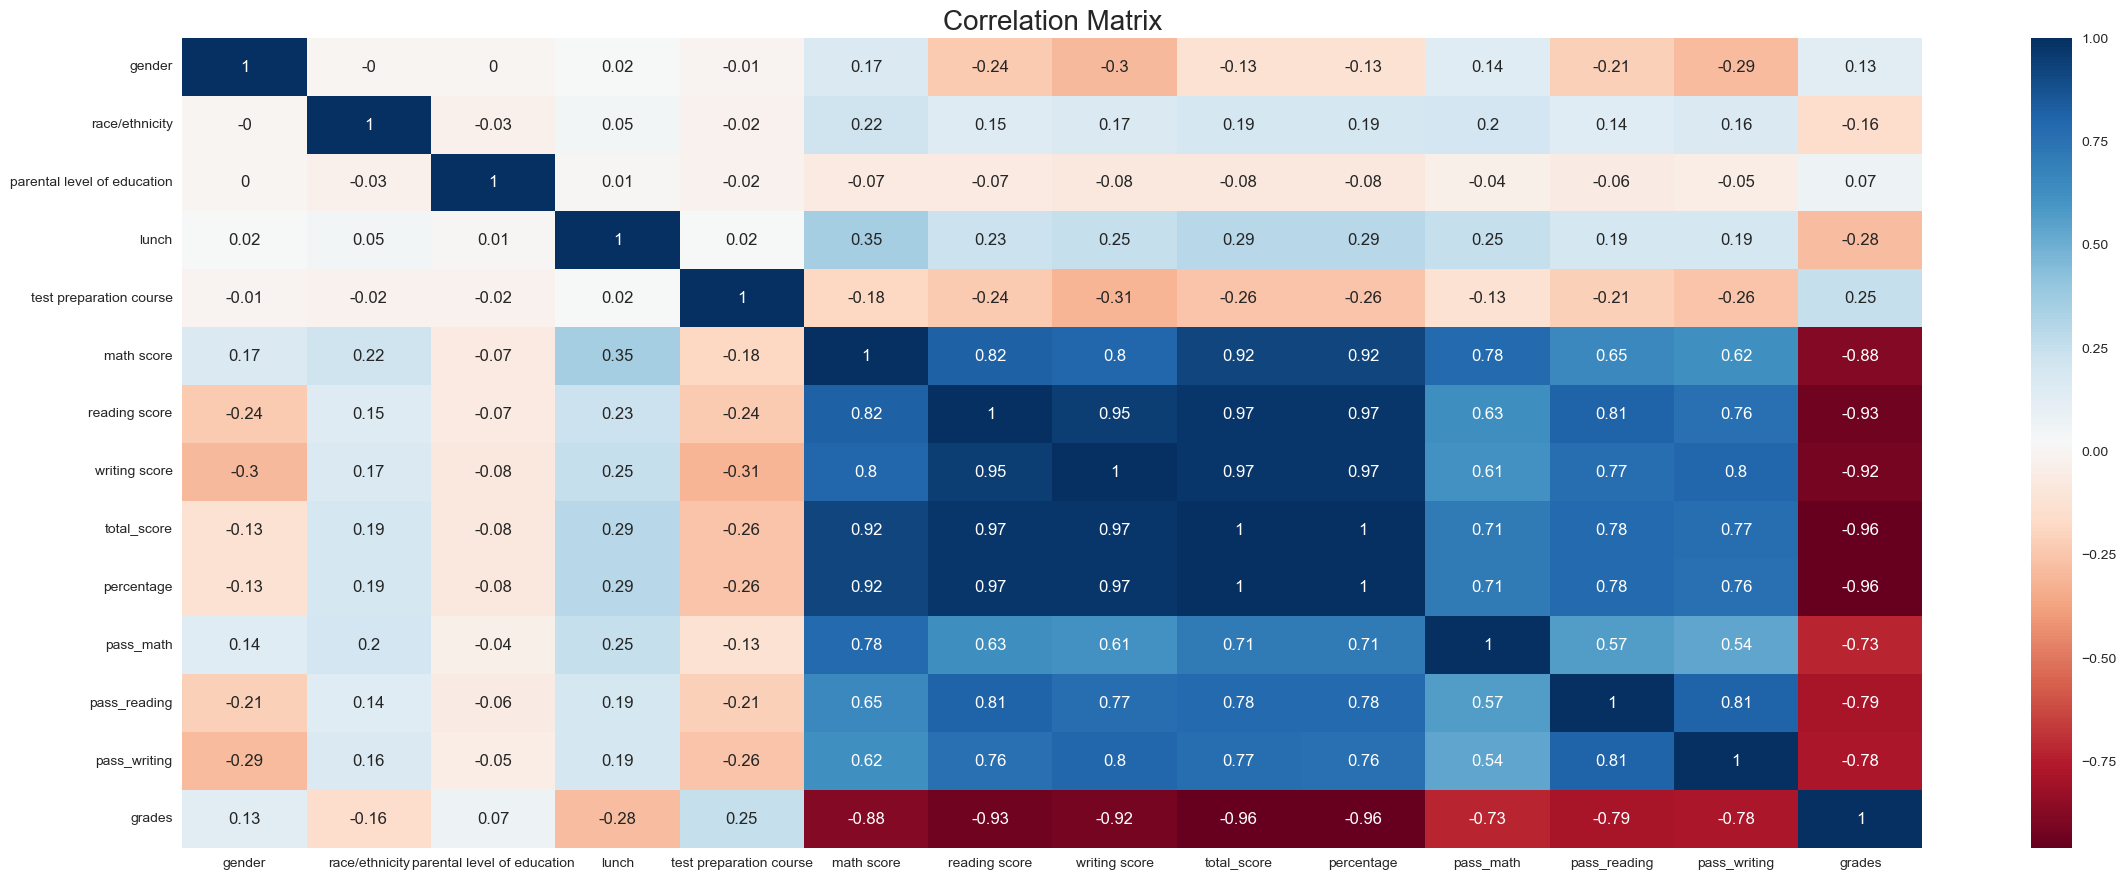

In [30]:
corr_data = data[numerical_columns].corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


# 5 Neural Network Algoritms

In [45]:

X = data.drop(columns=['grades']).values
Y = data['grades']

print(Counter(Y))
# sampling = RandomUnderSampler()
sampling = SMOTE()
X, Y = sampling.fit_resample(X, Y)
print(Counter(Y))

Y = pd.get_dummies(Y).values

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

label = y_train.shape[1]

Counter({2: 260, 3: 252, 4: 248, 1: 156, 0: 58, 5: 26})
Counter({2: 260, 1: 260, 0: 260, 4: 260, 3: 260, 5: 260})
(1095, 13) (1095, 6)
(309, 13) (309, 6)
(156, 13) (156, 6)


In [47]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1],)))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(Dense(label, activation='softmax'))
    
    return model

def CNN_Model():
    model = Sequential()

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(16, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add((LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add((LSTM(256)))
    # model.add(Dense(32, activation='swish'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(label, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(label, activation='softmax'))
    return model
    

model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.000_1)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              14336     
                                                                 
 dense_9 (Dense)             (None, 256)               262400    
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 6)                 390       
                                                                 
Total params: 293,574
Trainable params: 293,574
Non-trainable params: 0
_________________________________________________________________


In [54]:
num_epoch = 10
batch_size = 32

history = model.fit(X_train, y_train, verbose = 2,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

Epoch 1/10
35/35 - 0s - loss: 0.3948 - accuracy: 0.9890 - val_loss: 0.4288 - val_accuracy: 0.9450 - 196ms/epoch - 6ms/step
Epoch 2/10
35/35 - 0s - loss: 0.3885 - accuracy: 0.9890 - val_loss: 0.4177 - val_accuracy: 0.9579 - 159ms/epoch - 5ms/step
Epoch 3/10
35/35 - 0s - loss: 0.3848 - accuracy: 0.9890 - val_loss: 0.4266 - val_accuracy: 0.9417 - 150ms/epoch - 4ms/step
Epoch 4/10
35/35 - 0s - loss: 0.3790 - accuracy: 0.9872 - val_loss: 0.4133 - val_accuracy: 0.9547 - 151ms/epoch - 4ms/step
Epoch 5/10
35/35 - 0s - loss: 0.3719 - accuracy: 0.9927 - val_loss: 0.4023 - val_accuracy: 0.9644 - 180ms/epoch - 5ms/step
Epoch 6/10
35/35 - 0s - loss: 0.3689 - accuracy: 0.9890 - val_loss: 0.3968 - val_accuracy: 0.9644 - 137ms/epoch - 4ms/step
Epoch 7/10
35/35 - 0s - loss: 0.3640 - accuracy: 0.9927 - val_loss: 0.3977 - val_accuracy: 0.9547 - 136ms/epoch - 4ms/step
Epoch 8/10
35/35 - 0s - loss: 0.3599 - accuracy: 0.9909 - val_loss: 0.3919 - val_accuracy: 0.9612 - 111ms/epoch - 3ms/step
Epoch 9/10
35/35

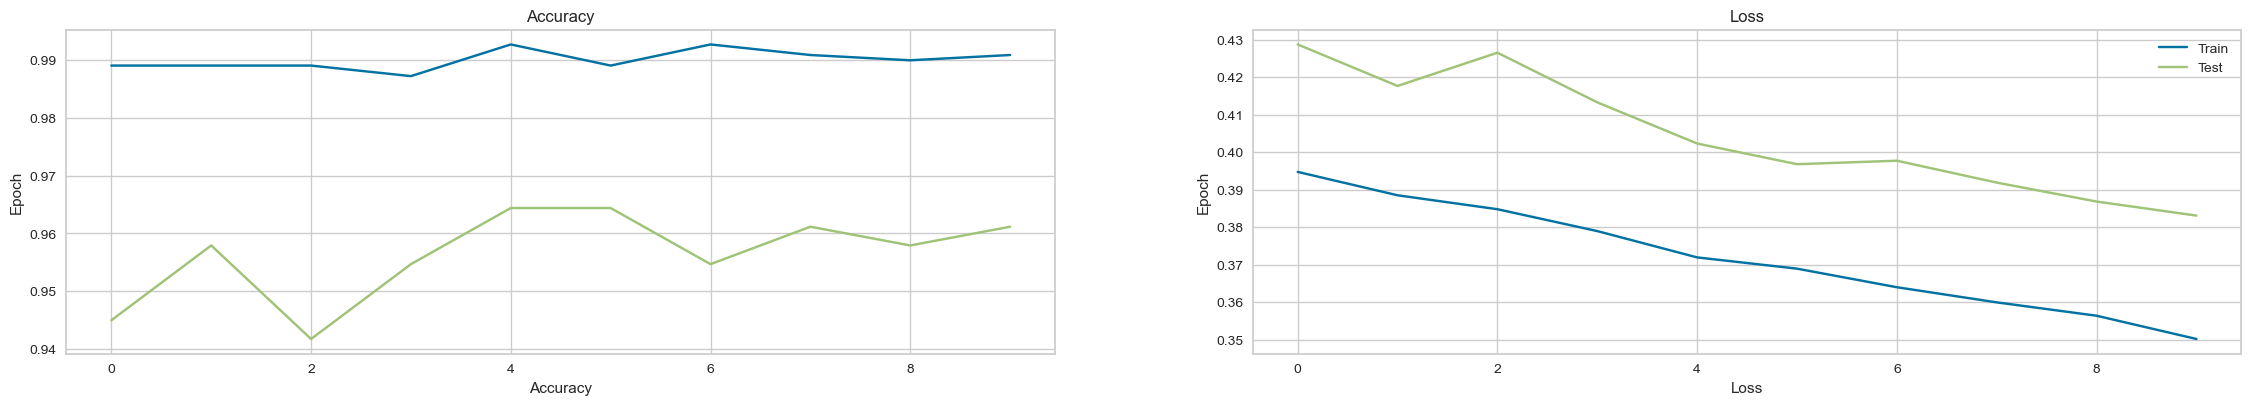

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [56]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(X_val, verbose=0))

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       0.91      0.95      0.93        22
           2       1.00      0.94      0.97        32
           3       0.89      1.00      0.94        24
           4       1.00      0.88      0.93        24
           5       1.00      1.00      1.00        26

   micro avg       0.96      0.96      0.96       156
   macro avg       0.96      0.96      0.96       156
weighted avg       0.96      0.96      0.96       156
 samples avg       0.96      0.96      0.96       156



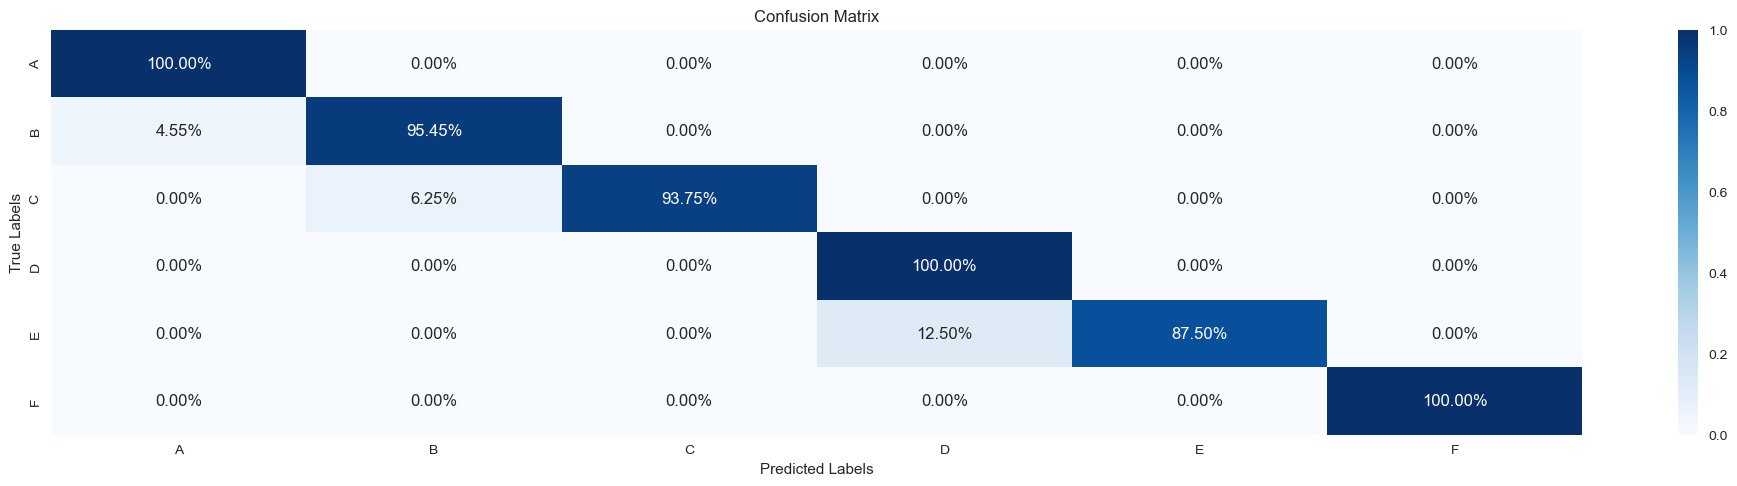

In [57]:
labels = ['A', 'B', 'C', 'D', 'E', 'F']

y_pred = np.rint(model.predict(X_val, verbose=0).argmax(axis=1))
con_mat = confusion_matrix(y_val.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 6. Supervised Learning

In [58]:
X = data.drop(columns=['grades']).values
Y = data['grades']

print(Counter(Y))
# undersample = RandomUnderSampler()
undersample = SMOTE()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = Y.values

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state = 42)

print(X_train.shape)
print(X_test.shape)

Counter({2: 260, 3: 252, 4: 248, 1: 156, 0: 58, 5: 26})
Counter({2: 260, 1: 260, 0: 260, 4: 260, 3: 260, 5: 260})
(1404, 13)
(156, 13)


### 6.2 Stacking Classifier

In [59]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradient = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
pac = PassiveAggressiveClassifier(random_state=42)
linear = LogisticRegression(random_state=42)

model = StackingClassifier([
    ('bagging', bagging),
    ('adaboost', adaboost),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('decisionTree', decisionTree),
    ('histGradient', histGradient),
    ('XGB', XGB),
    ('pac', pac),
    ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
], n_jobs=-1)

In [60]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('randomforest',
                                RandomForestClassifier(max_depth=100, n_jobs=-1,
                                                       random_state=42)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       r...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('pac',
                                PassiveAggressiveClassifier(random_state=42)),
                               ('linear', LogisticRegression(random_state=42))],
                   n_jobs=-1)

In [61]:
print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')

Train Score :  100.0 %
Test Score  :  100.0 %


In [62]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        32
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        26

    accuracy                           1.00       156
   macro avg       1.00      1.00      1.00       156
weighted avg       1.00      1.00      1.00       156



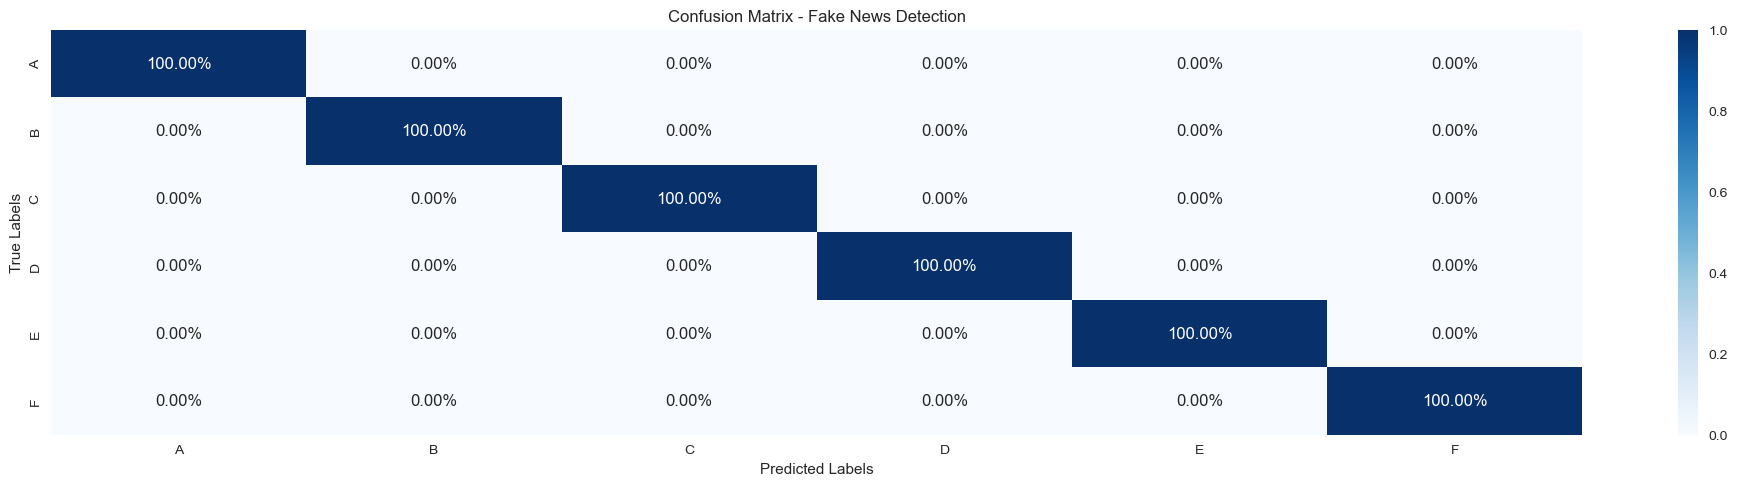

In [63]:
labels = ['A', 'B', 'C', 'D', 'E', 'F']

y_pred = model.predict(X_test)
con_mat = confusion_matrix(y_test,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

### 6.2. Pycaret

In [45]:
s = ClassificationExperiment()
s.setup(data, target = 'target', session_id = 123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(302, 14)"
4,Transformed data shape,"(302, 14)"
5,Transformed train set shape,"(211, 14)"
6,Transformed test set shape,"(91, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


In [46]:
best = s.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:18:11
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
s.evaluate_model(best)


In [48]:
print(best)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [49]:
s.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8462,0.9082,0.9184,0.8182,0.8654,0.6873,0.6935


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,prediction_label,prediction_score
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0,0,0.9656
276,58,1,0,146,218,0,1,105,0,2.0,1,1,3,0,0,0.9710
84,42,0,0,102,265,0,0,122,0,0.6,1,0,2,1,1,0.6207
141,43,1,0,115,303,0,1,181,0,1.2,1,0,2,1,1,0.6176
226,62,1,1,120,281,0,0,103,0,1.4,1,1,3,0,0,0.9002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2,1,1,0.9173
11,48,0,2,130,275,0,1,139,0,0.2,2,0,2,1,1,0.9615
81,45,1,1,128,308,0,0,170,0,0.0,2,0,2,1,1,0.8216
162,41,1,1,120,157,0,1,182,0,0.0,2,0,2,1,1,0.9372


In [12]:
lgbm = s.create_model('xgboost')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:02:50
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7718,0.8167,0.7180,0.7497,0.7335,0.5342,0.5346
1,0.7747,0.8213,0.7183,0.7547,0.7360,0.5396,0.5401
2,0.7757,0.8226,0.7208,0.7552,0.7376,0.5419,0.5424
3,0.7683,0.8147,0.7119,0.7465,0.7288,0.5267,0.5272
4,0.7714,0.8189,0.7178,0.7491,0.7331,0.5334,0.5337
5,0.7700,0.8144,0.7148,0.7482,0.7311,0.5304,0.5308
6,0.7762,0.8220,0.7227,0.7552,0.7386,0.5432,0.5436
7,0.7739,0.8207,0.7208,0.7520,0.7361,0.5385,0.5389
8,0.7744,0.8216,0.7189,0.7538,0.7360,0.5392,0.5397


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
X = data.drop(columns=['satisfaction']).values
Y = data['satisfaction']

In [37]:
scores = cross_val_score(lgbm, X_train, y_train, cv=20)

NameError: name 'X_train' is not defined

<Axes: >

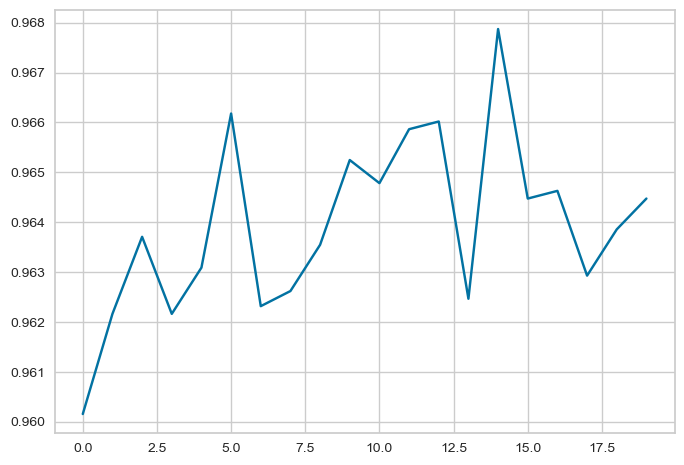

In [22]:
sns.lineplot(scores)

In [16]:
preds = s.predict_model(lgbm)
preds

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7745,0.8197,0.7199,0.7531,0.7362,0.5394,0.5399


In [36]:
pred = (abs(preds['satisfaction'] - preds['prediction_label'])).sum()

print(f'{pred} / {preds.shape[0]} : {round(pred/preds.shape[0]*100, 2)} % (False Predictions)')

33248 / 147438 : 22.55 % (False Predictions)
